# Półmaraton Wrocław 2023

## 1. Import bibliotek

In [2]:
from dotenv import load_dotenv
from io import BytesIO
import pycaret
from pycaret.regression import *
import boto3
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
from itables import show


# Dane dostępu z załadowane z pliku.env
load_dotenv()

True

## 2. Komunikacja z Digital Ocean

In [3]:
# Klient s3
s3 = boto3.client('s3')
# Nazwa kontenera w Digital Ocean
BUCKET_NAME='maraton'

In [4]:
# Wysłanie plików do kontenera
s3.upload_file(
    'data/halfmarathon_wroclaw_2023__final.csv',
    Bucket = BUCKET_NAME,
    Key = 'data/halfmarathon_wroclaw_2023__final.csv'
)
s3.upload_file(
    'data/halfmarathon_wroclaw_2024__final.csv',
    Bucket = BUCKET_NAME,
    Key = 'data/halfmarathon_wroclaw_2024__final.csv'
)

## 3. Funkcje

In [5]:
# Zmiana czasu uzyskanego przez zawodników z formatu h:m:s, na sekundy
def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [6]:
def download_to_df(file):
    obj = s3.get_object(Bucket=BUCKET_NAME, Key=file)
    return pd.read_csv(BytesIO(obj['Body'].read()), sep=";")


In [7]:
def seconds_to_time(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

## 4. Dataframe

In [87]:
# Wczytanie danych z plików do DataFrame
files = [
    'data/halfmarathon_wroclaw_2023__final.csv',
    'data/halfmarathon_wroclaw_2024__final.csv'
]

df = pd.concat(
    [download_to_df(file) for file in files],
    ignore_index=True
)
show(df)

Loading ITables v2.4.0 from the internet... (need help?)


In [88]:
# Sprawdź duplikaty w df
df.duplicated().sum()


0

In [89]:
# Zmiana czasu uzyskanego przez zawodników z formatu h:m:s, na sekundy
# Przeszukaj nazwy kolumn i zastosuj funkcję do tych, które zawierają słowo "Czas"
for kolumna in df.columns:
    if 'Czas' in kolumna:
        df[kolumna] = df[kolumna].apply(convert_time_to_seconds)

df.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,2687.0,1.0,3.106667,3703.0,1.0,3.386667,0.031400,3899.0,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,2726.0,2.0,3.143333,3788.0,2.0,3.540000,0.038000,3983.0,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,2854.0,3.0,3.236667,3909.0,3.0,3.516667,0.024067,4104.0,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,2929.0,5.0,3.330000,4014.0,4.0,3.616667,0.025467,4216.0,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,2971.0,7.0,3.386667,4047.0,5.0,3.586667,0.023000,4227.0,3.339654


### Brakujące wartości

In [90]:
# Wyswietl wszystkie wiersze, gdzie 5 km Czas i Czas jest NaN
df[df['5 km Czas'].isna() & df['Czas'].isna()]

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
8150,NaN,7890,PATRYCJA,ADAMISZYN,NaN,NaN,NaN,K,NaN,K20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8151,NaN,8199,JACOB,ADAMS,NaN,NaN,NaN,M,NaN,M20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8152,NaN,2392,MARIUSZ,ADAMSKI,NaN,NaN,Zefka Runners,M,NaN,M30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8153,NaN,6105,MARCIN,ADAMSKI,NaN,NaN,NaN,M,NaN,M40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8154,NaN,6851,ADAM,ADAMSKI,NaN,NaN,NaN,M,NaN,M60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21952,NaN,6445,ANNA,ŻUROWSKA,NaN,NaN,NaN,K,NaN,K40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21953,NaN,23495,JUSTYNA,ŻYGADŁO,NaN,NaN,NaN,K,NaN,K20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21954,NaN,9323,DAWID,ŻYTKOWSKI,NaN,NaN,NaN,M,NaN,M20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21955,NaN,27386,DOMINIKA,ĆWIERTNIA,NaN,NaN,NaN,K,NaN,K30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Usuń wiersze, gdzie 5 km Czas i Czas jest NaN
df = df[~df['5 km Czas'].isna() & ~df['Czas'].isna()]

In [92]:
# Wyświetl kolumny z brakującymi danymi
braki = df.isna().sum().reset_index(name='Ilość').nlargest(27, 'Ilość')
braki.columns = ['Kolumna', 'Ilość']
braki['Procent (%)'] = (braki['Ilość'] / len(df) * 100).round(2)
braki.style.bar(
    subset='Procent (%)',
    color='blue',
    align='left',
    vmin=0,
    vmax=100
).hide(axis='index').format(precision=2)

Kolumna,Ilość,Procent (%)
Drużyna,11281,61.27
Miasto,673,3.66
Rocznik,484,2.63
Tempo Stabilność,34,0.18
15 km Tempo,29,0.16
20 km Tempo,22,0.12
Kategoria wiekowa,18,0.10
Kategoria wiekowa Miejsce,18,0.10
10 km Miejsce Open,16,0.09
15 km Miejsce Open,16,0.09


### Usuwamy brakujące wartości

In [93]:
# parametr thresh pozwala określić minimalną liczbę nie-NaN wartości, 
# które muszą być w wierszu(axis=0)/kolumnie(axis=1)
df = df.dropna(thresh=(0.60*len(df)),axis=1)

# w tym przypadku kolumna Drużyna jest, ponieważ ma wiecej niż 60% brakujących wartości

### Wartości odstające

In [94]:
Q1 = df["Czas"].quantile(0.25)
Q3 = df["Czas"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[~((df["Czas"] < lower_bound) | (df["Czas"] > upper_bound))]

### Ustalamy wiek zawodników

In [95]:
# Wypełnij brakujące wartości w kolumnie Płeć
df['Płeć'] = df['Płeć'].fillna(df['Płeć'].mode()[0])

In [96]:
# Oblicz wiek zawodników
df['Wiek'] = 2024 - df['Rocznik']
# Zamień wartości w kolumnie Płeć na 0 i 1
df['Płeć'] = df['Płeć'].map({'M': 0, 'K': 1})

In [97]:
# Wypełnij brakujące wartości w kolumnie Wiek
df['Wiek'] = df['Wiek'].fillna(df['Wiek'].mean())

In [98]:
# Sortuje 5 km Tempo rosnaco
df = df.sort_values(by='5 km Tempo', ascending=True)
# Wykonuje forward fill dla 5 km Tempo
df['5 km Tempo'] = df['5 km Tempo'].fillna(method='ffill')
# Wykonuje interpolację dla 5 km Czas
df['5 km Czas'] = df['5 km Czas'].interpolate(method='linear')

In [99]:
# Sortuje df po Tempo
df = df.sort_values(by='Tempo', ascending=True)
# Wykonuje forward fill dla Tempo
df['Tempo'] = df['Tempo'].fillna(method='ffill')
# Wykonuje interpolation dla Czas
df['Czas'] = df['Czas'].interpolate(method='linear')

In [100]:
df['5 km Czas'].describe()

count    18185.000000
mean      1668.717404
std        238.390897
min          0.000000
25%       1502.000000
50%       1659.000000
75%       1830.000000
max       3825.000000
Name: 5 km Czas, dtype: float64

In [101]:
#wyświetl wszystkie wiersze gdzie 5 km Czas jest równe 0
df[df['5 km Czas'] == 0]

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Wiek
11579,2630.0,1318,BARTOSZ,WOJCIECHOWSKI,BRZEG DOLNY,POL,0,2356.0,M30,845.0,...,4706.0,3084.0,5.28,6283.0,2732.0,5.256667,0.212867,6617.0,5.227937,31.0


In [102]:
#usun wiersze gdzie 5 km Czas jest równe 0
df = df[df['5 km Czas'] != 0]
#wyświetl wszystkie wiersze gdzie 5 km Czas jest równe 0
df[df['5 km Czas'] == 0]

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Płeć,Płeć Miejsce,Kategoria wiekowa,Kategoria wiekowa Miejsce,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Wiek


In [146]:
# utworz kolumne WiekTempo
df['WiekTempo']=df['Tempo']/df['Wiek']

In [147]:
# utworz kolumne 5 km Czas K, tylko kobiety
df['5 km Czas K'] = df.apply(lambda row: row['5 km Czas'] if row['Płeć'] == 1 else None, axis=1)
# utworz kolumne 5 km Czas M, tylko mężczyźni
df['5 km Czas M'] = df.apply(lambda row: row['5 km Czas'] if row['Płeć'] == 0 else None, axis=1)

In [148]:
# utworz kolumne 5 Tempo M, tylko mężczyźni
df['5 km Tempo M'] = df.apply(lambda row: row['5 km Tempo'] if row['Płeć'] == 0 else None, axis=1)
# utworz kolumne 5 Tempo K, tylko kobiety
df['5 km Tempo K'] = df.apply(lambda row: row['5 km Tempo'] if row['Płeć'] == 1 else None, axis=1)


In [83]:
# # uzupełnij brakujące wartości
# df['5 km Czas M'].fillna(df['5 km Czas M'].mean(), inplace=True)
# df['5 km Czas M']=df['5 km Czas M'].round(0)
# df['5 km Czas K'].fillna(df['5 km Czas K'].mean(), inplace=True)
# df['5 km Czas K']=df['5 km Czas K'].round(0)

In [149]:
#usun wartosci odstajace 5 km Czas M
Q1 = df["5 km Czas M"].quantile(0.25)
Q3 = df["5 km Czas M"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[~((df["5 km Czas M"] < lower_bound) | (df["5 km Czas M"] > upper_bound))]

#usun wartosci odstajace 5 km Czas K
Q1 = df["5 km Czas K"].quantile(0.25)
Q3 = df["5 km Czas K"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[~((df["5 km Czas K"] < lower_bound) | (df["5 km Czas K"] > upper_bound))]


<Axes: xlabel='Płeć', ylabel='5 km Czas M'>

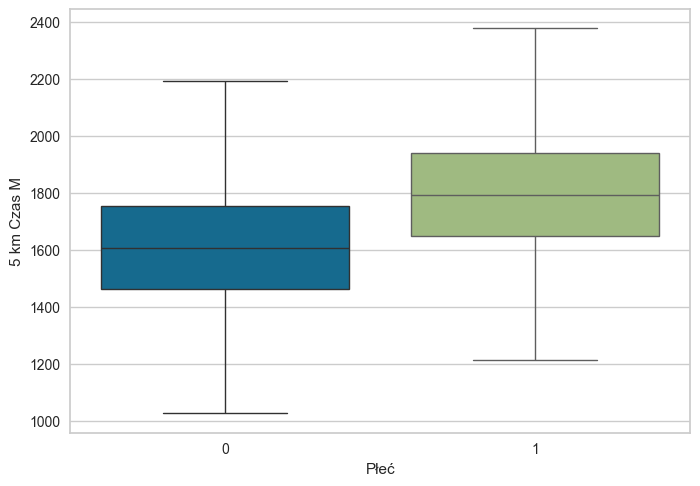

In [150]:
#wyswietl boxplot dla 5 km Czas M
sns.boxplot(x='Płeć', y='5 km Czas M', data=df)
#wyswietl boxplot dla 5 km Czas K
sns.boxplot(x='Płeć', y='5 km Czas K', data=df)
#wyswietl boxplot dla 5 km Tempo M


In [151]:
#usun wartosci odstajace 5 km Tempo M
Q1 = df["5 km Tempo M"].quantile(0.25)
Q3 = df["5 km Tempo M"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[~((df["5 km Tempo M"] < lower_bound) | (df["5 km Tempo M"] > upper_bound))]
#usun wartosci odstajace 5 km Tempo K
Q1 = df["5 km Tempo K"].quantile(0.25)
Q3 = df["5 km Tempo K"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[~((df["5 km Tempo K"] < lower_bound) | (df["5 km Tempo K"] > upper_bound))]

<Axes: xlabel='Płeć', ylabel='5 km Tempo K'>

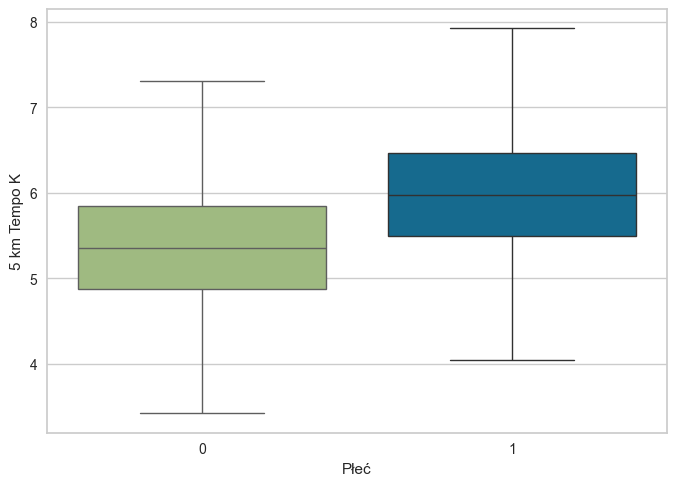

In [152]:
#wyswietl boxplot dla 5 km Tempo K
sns.boxplot(x='Płeć', y='5 km Tempo K', data=df)
#wyswietl boxplot dla 5 km Tempo M
sns.boxplot(x='Płeć', y='5 km Tempo M', data=df)



In [153]:
#usun wartosci odstajace WiekTempo
Q1 = df["WiekTempo"].quantile(0.25)
Q3 = df["WiekTempo"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[~((df["WiekTempo"] < lower_bound) | (df["WiekTempo"] > upper_bound))]


<Axes: xlabel='Płeć', ylabel='WiekTempo'>

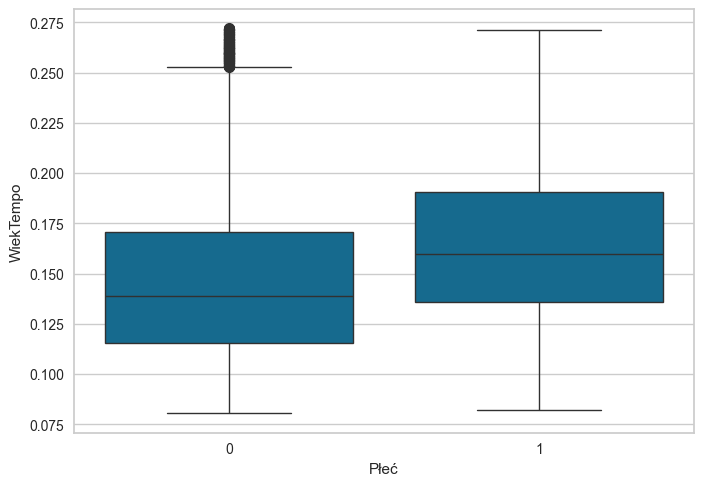

In [154]:
#wyswietl boxplot dla WiekTempo
sns.boxplot(x='Płeć', y='WiekTempo', data=df)

## 5. Trenowanie modelu

In [155]:
data = df[['Wiek', 'Płeć', '5 km Czas', '5 km Czas K', '5 km Czas M', '5 km Tempo', '5 km Tempo K', '5 km Tempo M','WiekTempo', 'Czas']]

In [156]:
# przygotuj 80% danych do trenowania i 20% do walidacji
train_data = data.sample(frac=0.8, random_state=42)
val_data = data.drop(train_data.index)



In [157]:
exp = setup(
    data=train_data,
    target='Czas',
    session_id=123,
    verbose=False,
    # Categorical encoding
    numeric_features=['Wiek', '5 km Czas', '5 km Czas K', '5 km Czas M','5 km Tempo','5 km Tempo K','5 km Tempo M','WiekTempo'],
    categorical_features=['Płeć']
)

In [158]:
exp.dataset.head()

,Wiek,Płeć,5 km Czas,5 km Czas K,5 km Czas M,5 km Tempo,5 km Tempo K,5 km Tempo M,WiekTempo,Czas
18488,36.0,0,1914.0,NaN,1914.0,6.380000,NaN,6.380000,0.205113,9346.0
17224,49.0,1,1960.0,1960.0,NaN,6.533333,6.533333,NaN,0.136329,8455.0
10150,38.0,0,1447.0,NaN,1447.0,4.823333,NaN,4.823333,0.126121,6066.0
15771,48.0,0,1606.0,NaN,1606.0,5.353333,NaN,5.353333,0.129293,7855.0
5747,46.0,1,1728.0,1728.0,NaN,5.760000,5.760000,NaN,0.135550,7892.0


In [159]:
exp.dataset_transformed.head()


,Wiek,Płeć,5 km Czas,5 km Czas K,5 km Czas M,5 km Tempo,5 km Tempo K,5 km Tempo M,WiekTempo,Czas
18488,36.0,0.0,1914.0,1782.708008,1914.00000,6.380000,5.942360,6.380000,0.205113,9346.0
17224,49.0,1.0,1960.0,1960.000000,1608.93689,6.533333,6.533333,5.363123,0.136329,8455.0
10150,38.0,0.0,1447.0,1782.708008,1447.00000,4.823333,5.942360,4.823333,0.126121,6066.0
15771,48.0,0.0,1606.0,1782.708008,1606.00000,5.353333,5.942360,5.353333,0.129293,7855.0
5747,46.0,1.0,1728.0,1728.000000,1608.93689,5.760000,5.760000,5.363123,0.135550,7892.0


In [160]:
best_model = exp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,40.3009,3064.8484,55.2561,0.9975,0.0079,0.0057,0.8960
xgboost,Extreme Gradient Boosting,68.4794,9401.5078,96.7829,0.9924,0.0129,0.0093,0.0510
lightgbm,Light Gradient Boosting Machine,98.0186,19271.8255,138.6484,0.9844,0.0192,0.0136,0.1190
rf,Random Forest Regressor,105.2386,29221.2977,170.5408,0.9765,0.0227,0.0143,0.3550
et,Extra Trees Regressor,153.7315,51805.3425,227.3854,0.9582,0.0300,0.0207,0.2020
dt,Decision Tree Regressor,147.1698,52563.0439,228.9553,0.9576,0.0304,0.0199,0.0160
gbr,Gradient Boosting Regressor,206.3563,75506.7196,274.6185,0.9391,0.0365,0.0278,0.1310
lr,Linear Regression,233.5287,101513.8416,318.4530,0.9181,0.0413,0.0312,0.3790
lar,Least Angle Regression,233.5080,101491.8273,318.4188,0.9181,0.0413,0.0312,0.0100
lasso,Lasso Regression,242.5856,107382.5470,327.5014,0.9133,0.0423,0.0322,0.2070


In [161]:
# tuning modelu
tuned_model = tune_model(
    best_model,
    optimize='MAE',
    search_library='scikit-learn',
    search_algorithm='random'
    )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,43.0495,4350.1678,65.9558,0.9967,0.0093,0.0061
1,44.4466,4565.2113,67.5663,0.9963,0.0089,0.0060
2,42.4465,3684.3733,60.6990,0.9970,0.0083,0.0058
3,44.2199,3931.6332,62.7027,0.9970,0.0090,0.0062
4,42.5787,4234.1814,65.0706,0.9962,0.0089,0.0059
5,40.5923,3550.8863,59.5893,0.9971,0.0081,0.0056
6,45.8046,6579.7403,81.1156,0.9948,0.0111,0.0063
7,40.6788,4168.9393,64.5673,0.9966,0.0082,0.0055
8,40.6388,2997.0305,54.7451,0.9976,0.0077,0.0057


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [162]:
# porównaj modele best_model i tuned_model
best = compare_models(include=[best_model, tuned_model], sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,CatBoost Regressor,40.3009,3064.8484,55.2561,0.9975,0.0079,0.0057,0.8290
1,CatBoost Regressor,40.3009,3064.8484,55.2561,0.9975,0.0079,0.0057,0.8180


In [163]:
# Zapisujemy model do pliku maraton_pipeline.pkl
final_model = finalize_model(best)
save_model(final_model, 'models/maraton_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Wiek', '5 km Czas', '5 km Czas K',
                                              '5 km Czas M', '5 km Tempo',
                                              '5 km Tempo K', '5 km Tempo M',
                                              'WiekTempo'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=OrdinalEncoder(cols=['Płeć'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'Płeć',
                

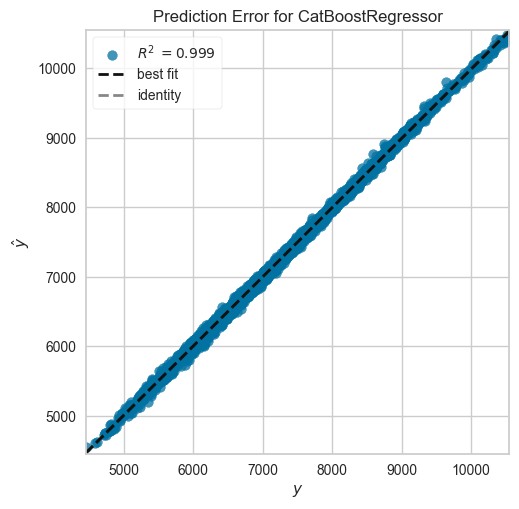

In [164]:
plot_model(final_model, plot='error')

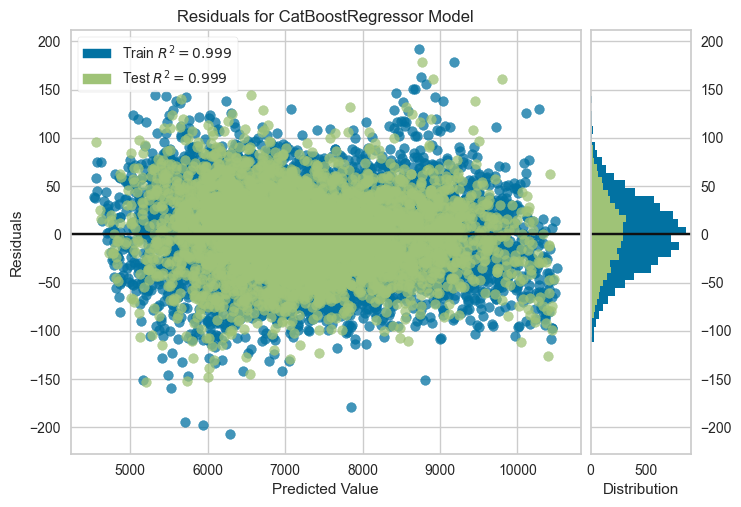

In [165]:
plot_model(final_model, plot='residuals')

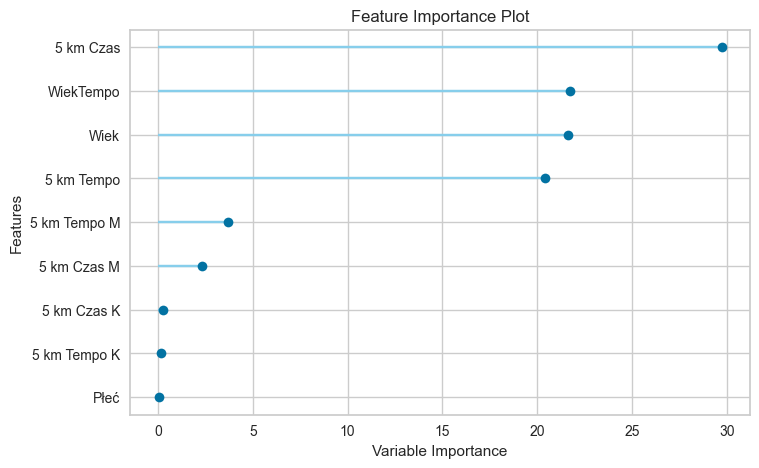

In [166]:
plot_model(final_model, plot='feature')

In [167]:
# wykonaj predykcje na danych do predykcji
predictions = predict_model(final_model, data=val_data)
predictions['prediction_label']

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,35.7576,2446.3836,49.4609,0.9980,0.0069,0.0050


10        4542.183364
15        4580.176076
21        4602.208204
8968      4676.927621
25        4676.927621
             ...     
19091    10379.810507
8054     10244.917216
19095    10412.629943
8056     10441.931177
19112    10518.741742
Name: prediction_label, Length: 3461, dtype: float64

In [168]:
# zapisz model do Digital Ocean w folderze models
s3.upload_file(
    'models/maraton_pipeline.pkl',
    Bucket=BUCKET_NAME,
    Key='models/maraton_pipeline.pkl'
)

